In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 256
errIndex = nTurn
betx = 1.9065054393933862
alfx = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
nx = 100
NL_t = 0.4
NL_c = 0.01
print('singular point = ', NL_c*np.sqrt(betx))
pipe_radius = 0.02*np.sqrt(2.0)
#pipe_radius = 0.013
#pipe_radius = 0.01

singular point =  0.013807626296338507


In [3]:
# H1 = 0.04005207 

# 1. Preparation

In [4]:
beam, lattice = impact.readInputFile('test_IOTA.in')

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.current = 0.0
beam.distribution.distribution_type = 'ReadFile'

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

### 1.2. generate particles

In [6]:
testP = 0.0
sig = 0.01
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-0.01,0.01,nx):
    for y in np.linspace(-0.01,0.01,nx):
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])            
            
pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)
impact.writeParticleData(pTest, ke, mass, freq)
beam.n_particles = nptTest

nptTest= 7668


### 1.3 adjust lattice

In [7]:
# L=0.0
# for i in range(len(lattice)):
#     if 'length' in lattice[i].keys():
#         L = L+lattice[i].length
# print(L)

for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = ceil(lattice[i].length*30)
        if lattice[i].type in ['nonlinear_insert','dipole']:
            lattice[i].n_sckick = ceil(lattice[i].length*60)
            lattice[i].n_map = 5
        else:
            lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]

# L=0.0
# for i in range(len(lattice)):
#     if 'length' in lattice[i].keys():
#         L = L+lattice[i].length
# print(L)

### 1.3 adjust lattice

In [8]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode, nSample = arr.shape
    diff = np.abs(ref-arr)
    for i in range(nMode):
        for j in range(nSample):
            if (diff[i,j]>0.5):
                diff[i,j] = 1.0 - diff[i,j]
    return np.min(diff,0)

# 2. Run

In [9]:
print('===========================')
print('=========== Run ===========')
print('===========================')

=========== Run ===========


In [10]:
TBT = impact.getElem('TBT')
TBT.file_id = errIndex
lattice.insert(1,TBT)

TBT_integral = impact.getElem('TBT_integral')
TBT_integral.file_id = errIndex
TBT_integral.betx = betx
TBT_integral.alfx = alfx
TBT_integral.strength_t = NL_t
TBT_integral.transverse_scale_c = NL_c
lattice.insert(2,TBT_integral)

lattice[0].turns = nTurn

In [ ]:
for i in range(len(lattice)):
    if lattice[i].type=='dipole':
        print(lattice[i])

In [ ]:
# for i in range(len(lattice)):
#     if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
#         lattice[i].pipe_radius = pipe_radius

In [11]:
impact.writeInputFile(beam,lattice) 
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

In [12]:
indexTBT,TBTdataTmp = impact.readTBT(errIndex,ke,mass,freq)
indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(errIndex)
TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2
pDataIn = impact.readParticleData(-111110,ke,mass,freq)
pDataOut= impact.readParticleData(-111111,ke,mass,freq)

pDataIn.shape (7668, 9)
pDataOut.shape (7295, 9)


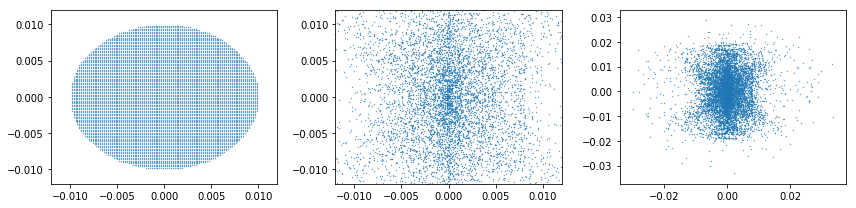

In [13]:
print('pDataIn.shape',pDataIn.shape)
print('pDataOut.shape',pDataOut.shape)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(pDataIn[:,0],pDataIn[:,2],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,2)
plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,3)
plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
plt.tight_layout()
plt.savefig('pData.InOut.png',dpi=180,bbox_inches = "tight")

(256, 6, 7299)


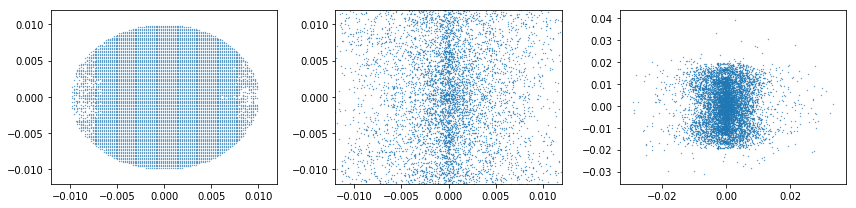

In [14]:
print(TBTdataTmp.shape)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(TBTdataTmp[0,0,:],TBTdataTmp[0,2,:],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,2)
plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,3)
plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
plt.tight_layout()
plt.savefig('TBTdata.InOut.png',dpi=180,bbox_inches = "tight")